### Описание данных

Таблица `market_file` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:

- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности: «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Таблица `market_money` содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка.
- `Выручка` — сумма выручки за период.

Таблица `market_time` содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

Таблица `money` содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю:

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

In [1]:
# Для установки раскомментить нужные библиотеки. 
!pip install phik
!pip install shap

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
import shap


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import(
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    f1_score,
    roc_auc_score 
)

In [3]:
pd.set_option('max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

### Загрузка данных

In [4]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv',sep=',')
    market_money = pd.read_csv('/datasets/market_money.csv',sep=',')
    market_time = pd.read_csv('/datasets/market_time.csv',sep=',')
    money = pd.read_csv('/datasets/money.csv',sep=';', decimal = ',')
    
except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv',sep=';')
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv',sep=',')
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv',sep=',')
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv',sep=';', decimal = ',')

In [5]:
def describer(data):
    display(data.head(10))
    data.info()
    print(f'Количество дубликатов: {data.duplicated().sum()}')
    if data.duplicated().sum() !=0 :
        display(data[data.duplicated()])

#### market_file

In [6]:
describer(market_file)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.10,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.70,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.20,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.90,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

#### market_money

In [7]:
describer(market_money)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,"3,293.10"
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,"4,472.00"
4,215349,текущий_месяц,"4,971.60"
5,215349,предыдущий_месяц,"5,216.00"
6,215350,препредыдущий_месяц,"4,826.00"
7,215350,текущий_месяц,"5,058.40"
8,215350,предыдущий_месяц,"5,457.50"
9,215351,текущий_месяц,"6,610.40"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
Количество дубликатов: 0


#### market_time

In [8]:
describer(market_time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
Количество дубликатов: 0


#### money

In [9]:
describer(money)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
Количество дубликатов: 0


В глаза бросается несколько опечаток в названиях столбцов. Типы данных корректные, пропусков нет. Подробнее посмотрим на этапе предобработки.

### Предобработка данных

In [10]:
# Приведем названия столбцов к одному стилю

market_file.rename(columns=
                   {'Покупательская активность': 'Покупательская_активность',
                    'Тип сервиса': 'Тип_сервиса',
                    'Разрешить сообщать': 'Разрешить_сообщать'}
                  , inplace=True)
market_file.columns

Index(['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [11]:
market_time.rename(columns={'минут': 'Минут'}, inplace=True)

In [12]:
# Проверим строковые категориальные столбцы на наличие неявных дубликатов и ошибок.

market_file['Покупательская_активность'].value_counts()

Прежний уровень    802
Снизилась          498
Name: Покупательская_активность, dtype: int64

In [13]:
market_file['Тип_сервиса'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: Тип_сервиса, dtype: int64

In [14]:
# Исправим опечатку

market_file['Тип_сервиса'] = market_file['Тип_сервиса'].replace('стандартт', 'стандарт')
market_file['Тип_сервиса'].value_counts()

стандарт    924
премиум     376
Name: Тип_сервиса, dtype: int64

In [15]:
market_file['Разрешить_сообщать'].value_counts()

да     962
нет    338
Name: Разрешить_сообщать, dtype: int64

In [16]:
market_file['Популярная_категория'].value_counts()

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64

In [17]:
market_money['Период'].value_counts()

предыдущий_месяц       1300
текущий_месяц          1300
препредыдущий_месяц    1300
Name: Период, dtype: int64

In [18]:
market_time['Период'].value_counts()

текущий_месяц       1300
предыдцщий_месяц    1300
Name: Период, dtype: int64

In [19]:
# Исправим опечатку

market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time['Период'].value_counts()

предыдущий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64

In [20]:
# Еще раз проверим количество дубликатов в таблицах, где заменяли значения

print(f'Количество дубликатов в market_file: {market_file.duplicated().sum()}')
print(f'Количество дубликатов в market_time: {market_time.duplicated().sum()}')

Количество дубликатов в market_file: 0
Количество дубликатов в market_time: 0


In [21]:
# Посмотрим какие значения встречаются в данных
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,"1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00"
mean,"215,997.50",4.25,4.01,601.90,0.32,3.27,2.84,4.19,8.18
std,375.42,1.01,0.70,249.86,0.25,1.36,1.97,1.96,3.98
min,"215,348.00",0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00
25%,"215,672.75",3.70,4.00,405.50,0.17,2.00,1.00,3.00,5.00
50%,"215,997.50",4.20,4.00,606.00,0.24,3.00,3.00,4.00,8.00
75%,"216,322.25",4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00
max,"216,647.00",6.60,5.00,"1,079.00",0.99,6.00,10.00,9.00,20.00


In [22]:
market_money.describe()

,id,Выручка
count,"3,900.00","3,900.00"
mean,"215,997.50","5,025.70"
std,375.33,"1,777.70"
min,"215,348.00",0.00
25%,"215,672.75","4,590.15"
50%,"215,997.50","4,957.50"
75%,"216,322.25","5,363.00"
max,"216,647.00","106,862.20"


Виден выброс. Посмотрим на него внимательнее позже.

In [23]:
market_time.describe()

,id,Минут
count,"2,600.00","2,600.00"
mean,"215,997.50",13.34
std,375.35,4.08
min,"215,348.00",4.00
25%,"215,672.75",10.00
50%,"215,997.50",13.00
75%,"216,322.25",16.00
max,"216,647.00",23.00


In [24]:
money.describe()

,id,Прибыль
count,"1,300.00","1,300.00"
mean,"215,997.50",4.00
std,375.42,1.01
min,"215,348.00",0.86
25%,"215,672.75",3.30
50%,"215,997.50",4.04
75%,"216,322.25",4.67
max,"216,647.00",7.43


Привели названия столбцов к единому стилю, удалили опечатки в данных. Провели проверку на наличие неявных дубликатов.  
- дубликатов нет
- неявных дубликатов нет
- пропусков в данных нет
- обнаружен выброс в таблице market_money, который мы посмотрим детальнее ниже

### Исследовательский анализ данных

In [25]:
'''
Функция принимает название датафрейма и название столбца
по которым строит: 
- столбчатую диаграмму в абсолютных цифрах 
- круговую диаграмму в относительных цифрах

'''

def cat_descr(data, column):
    
    #Количество, столбчатая
    plt.subplot(1, 2, 1)
    data[column].value_counts().sort_values().plot(kind='bar', figsize=(16,8), grid=True);
    plt.title(f'Количество покупателей по {column}')
    plt.ylabel('Count');
    for i in range(len(data[column].value_counts())):
          plt.text(i,
                   data[column].value_counts().sort_values()[i],
                   data[column].value_counts().sort_values()[i], ha = 'center')

    #Доля, пирог
    plt.subplot(1,2, 2)
    data[column].value_counts().plot(y='count', kind='pie', labeldistance=None, autopct="%1.1f%%")
    plt.title(f'Доля покупателей по {column}')
    plt.legend()
    plt.ylabel('')
    plt.show()

In [26]:
'''
Функция принимает название датафрейма, название столбца, количество корзин
по кторым строит:
- гистограмму с указанным количеством корзин
- диаграмму размаха

'''
def num_descr(data,column, bins):
    
    sns.set(style="ticks")
    
    x=data[column]
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16,8))

    sns.boxplot(x=x, ax=ax_box)
    sns.histplot(x=x, bins=bins, kde=True, ax=ax_hist)
    
    ax_box.set_title(f'Распределение покупателей по {column}')
    ax_box.set(yticks=[])
    ax_box.set(xlabel='')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

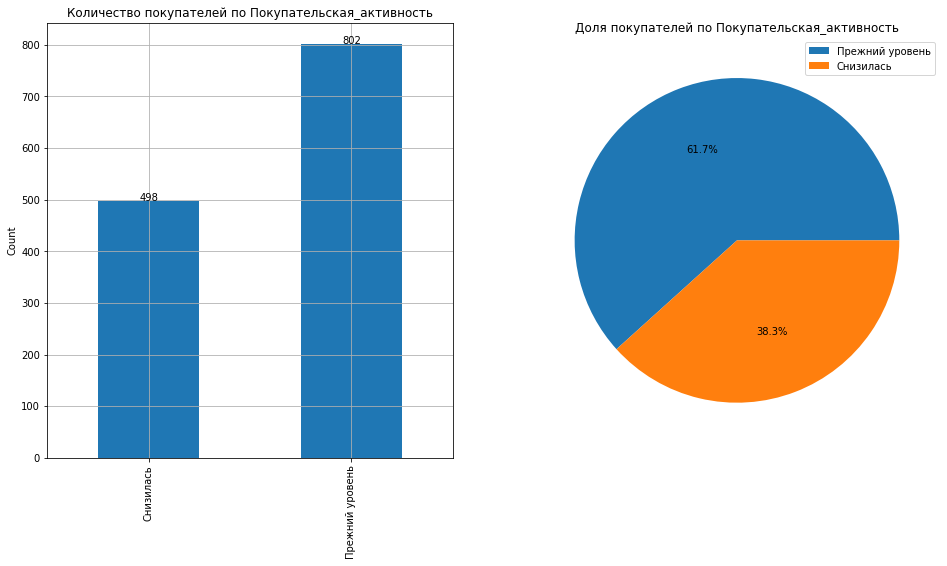

In [27]:
cat_descr(market_file,'Покупательская_активность')

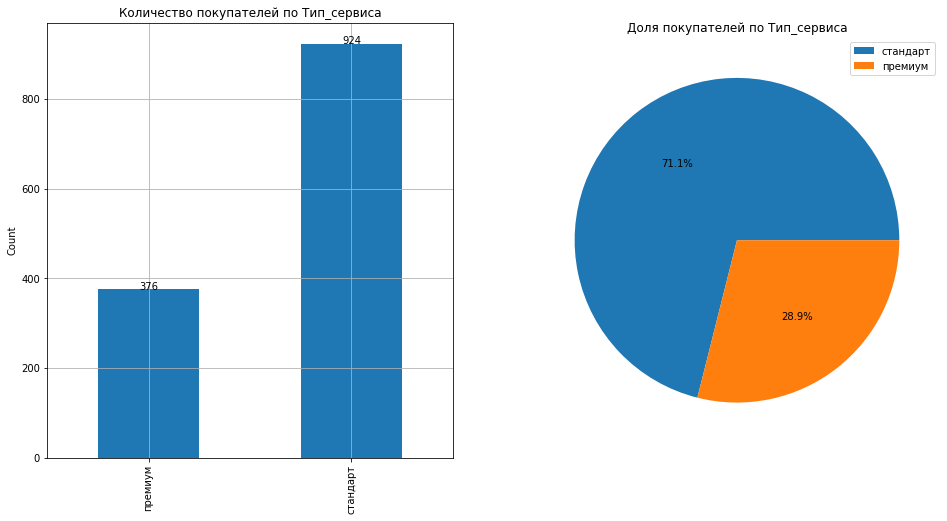

In [28]:
cat_descr(market_file,'Тип_сервиса')

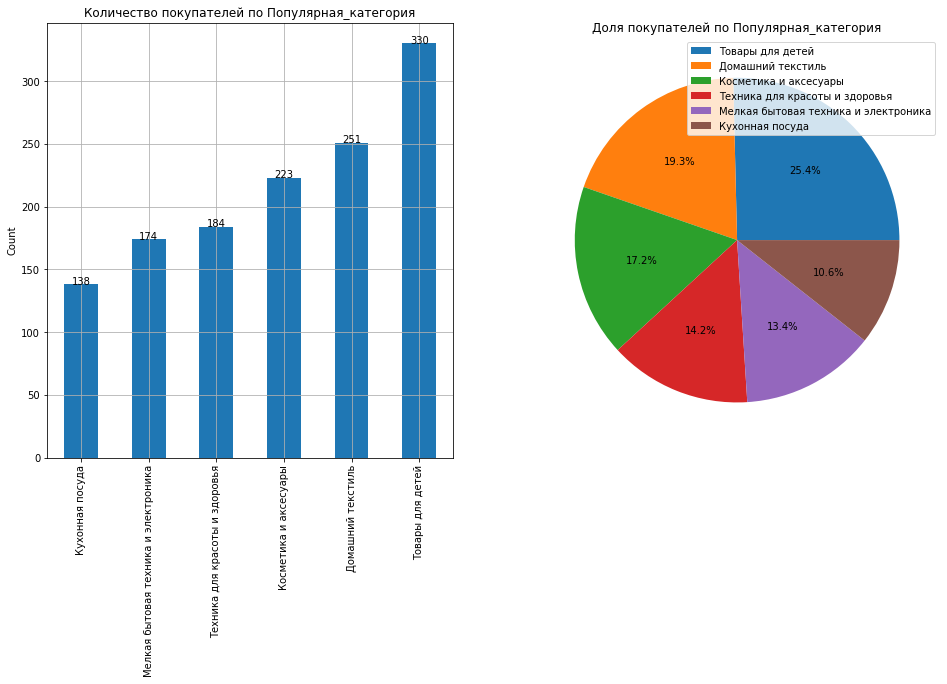

In [29]:
cat_descr(market_file,'Популярная_категория')

In [30]:
#num_descr(market_file,'Длительность', 12)

In [31]:
#num_descr(market_money,'Выручка',20)

In [32]:
num_columns_market_file = ['Маркет_актив_тек_мес', 'Маркет_актив_6_мес', 'Длительность',
               'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал','Ошибка_сервиса',
               'Страниц_за_визит']

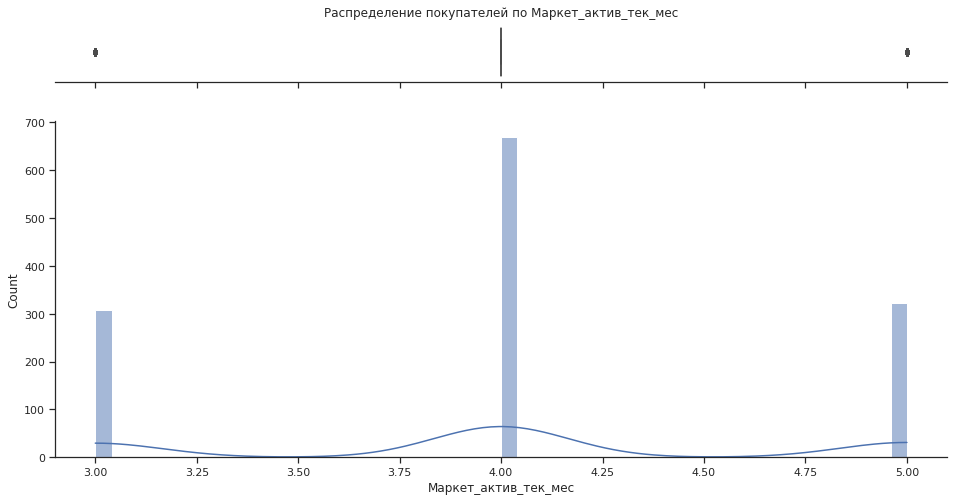

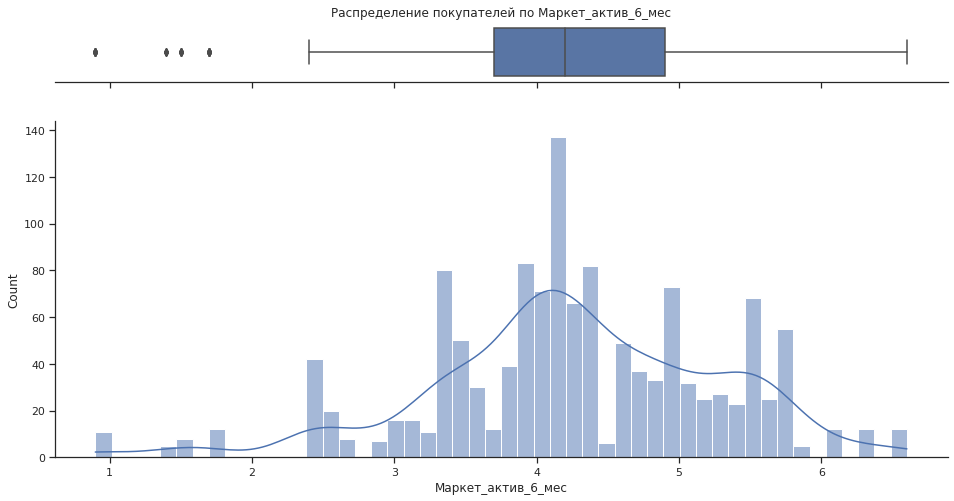

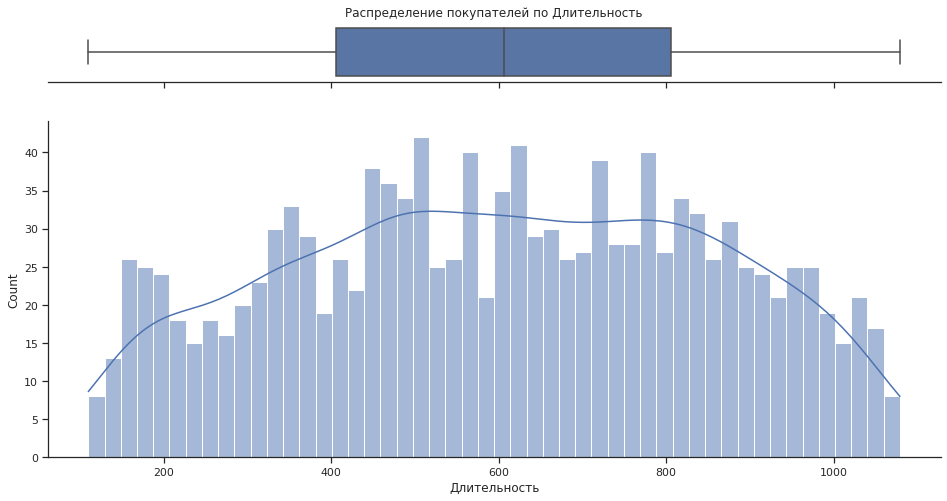

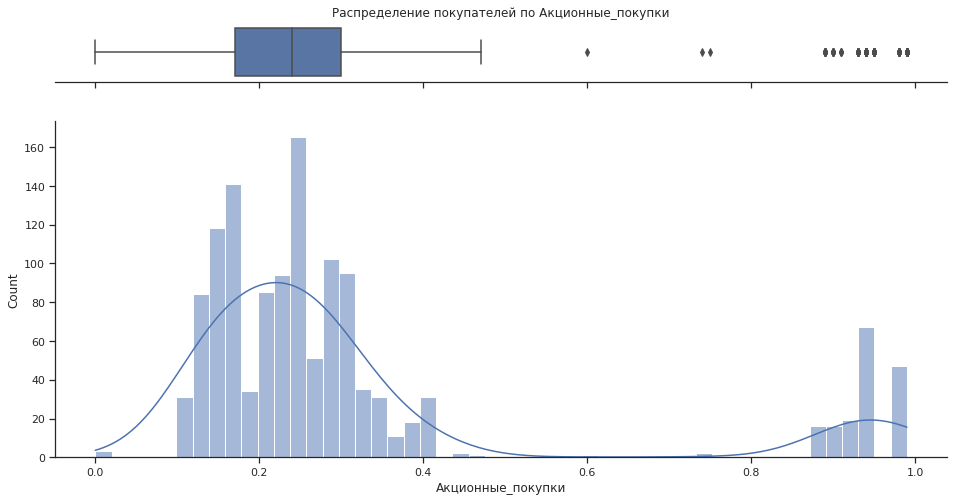

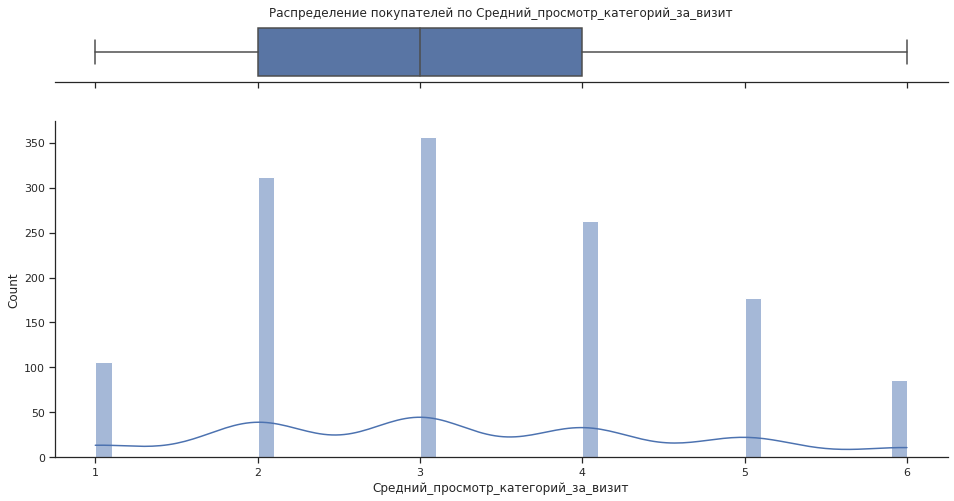

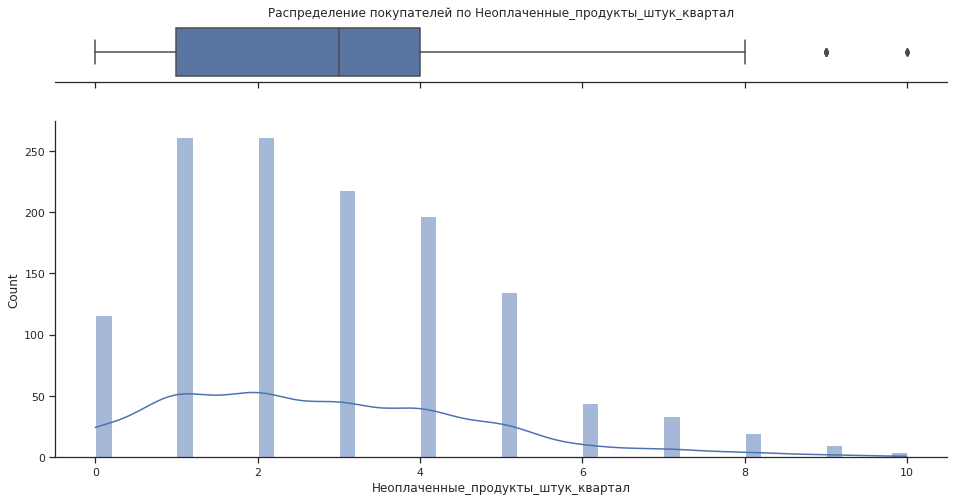

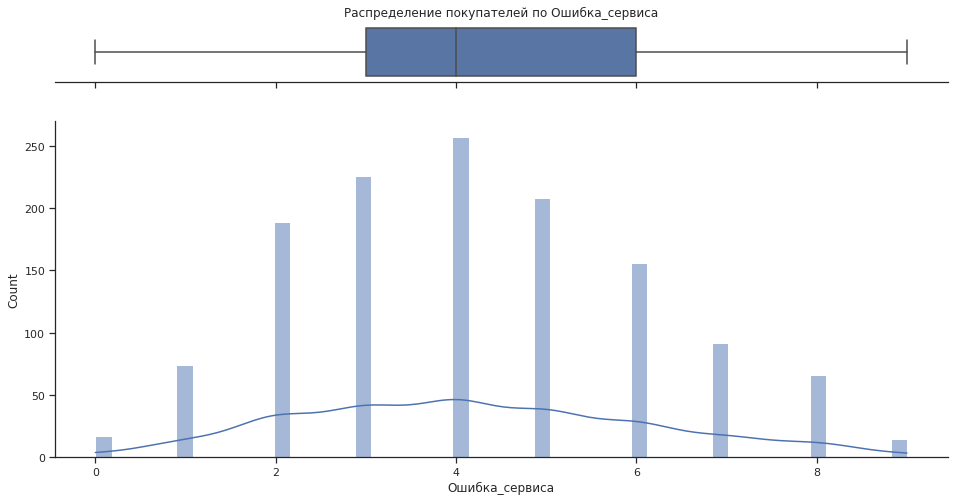

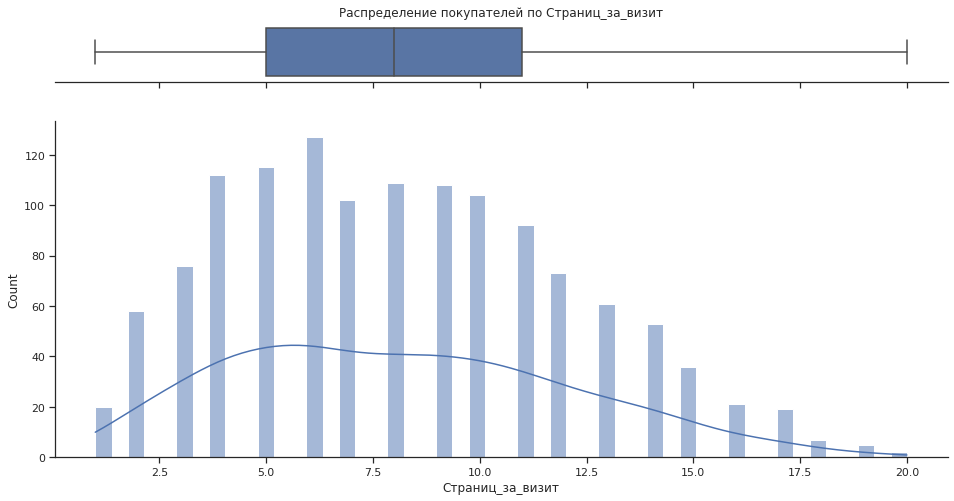

In [33]:
for cols in num_columns_market_file:
    num_descr(market_file,cols,50)

In [34]:
market_money['Выручка'].describe(percentiles=[0.005, .25, .5, .75, .995])

count     3,900.00
mean      5,025.70
std       1,777.70
min           0.00
0.5%      3,130.00
25%       4,590.15
50%       4,957.50
75%       5,363.00
99.5%     7,160.45
max     106,862.20
Name: Выручка, dtype: float64

In [35]:
# 99% значений укладываются в диапазон 3130-7160. 
market_money.query('Выручка > 7799 | Выручка < 3130')

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
2,215348,предыдущий_месяц,0.00
28,215357,препредыдущий_месяц,0.00
29,215357,предыдущий_месяц,0.00
34,215359,предыдущий_месяц,0.00
35,215359,препредыдущий_месяц,0.00
98,215380,текущий_месяц,"106,862.20"
356,215466,текущий_месяц,"2,758.70"
390,215478,текущий_месяц,"3,078.30"
392,215478,предыдущий_месяц,"2,960.00"


Выручка за текущий_месяц
count   1,299.00
mean    5,236.79
std       835.47
min     2,758.70
25%     4,705.50
50%     5,179.60
75%     5,759.95
max     7,799.40
Name: Выручка, dtype: float64


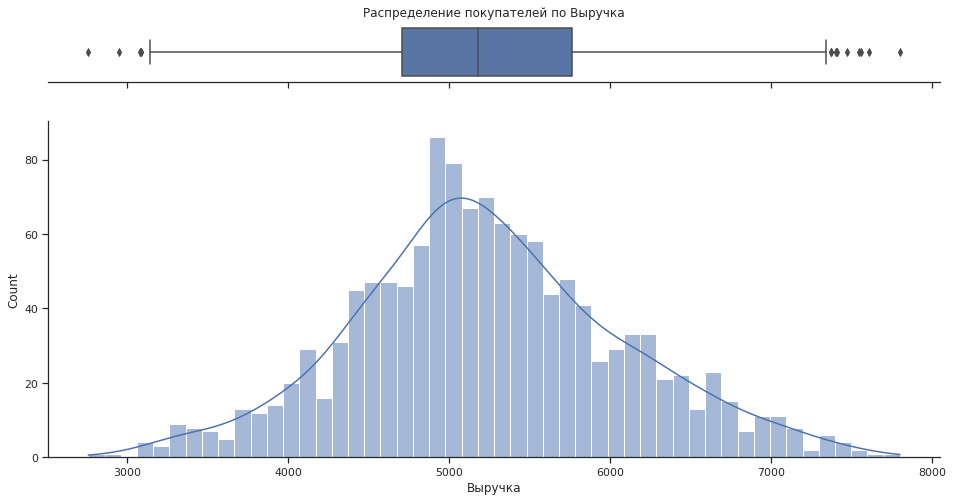

In [36]:
# Удалим нулевые значения (возможно, это новые клиенты, для анализа не нужны) и сильно выбивающееся значение с индексом 98
market_money = market_money.query('Выручка > 0 & Выручка < 7800')

print('Выручка за текущий_месяц')
print(market_money.query('Период == "текущий_месяц"')['Выручка'].describe())
num_descr(market_money.query('Период == "текущий_месяц"'), 'Выручка', 50)


Выручка за предыдущий месяц
count   1,297.00
mean    4,948.34
std       701.23
min     2,890.00
25%     4,498.50
50%     5,005.50
75%     5,409.00
max     6,869.50
Name: Выручка, dtype: float64


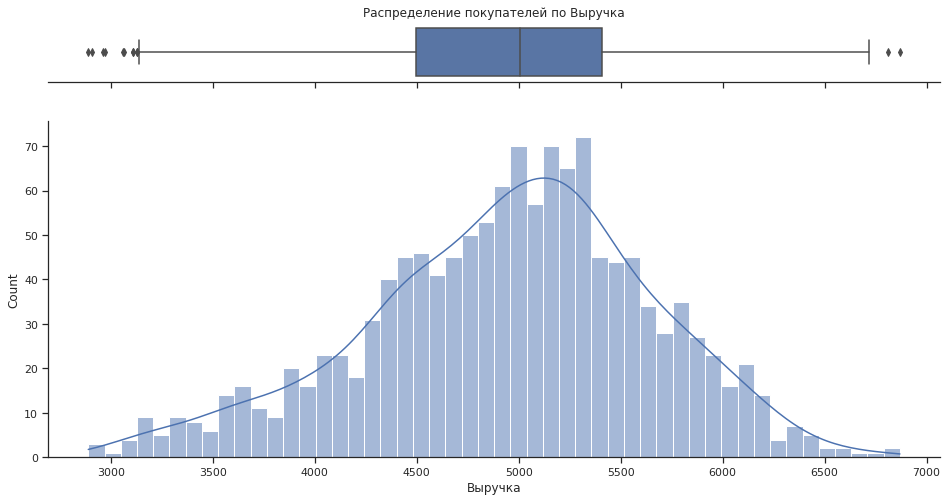

In [37]:
print('Выручка за предыдущий месяц')
print(market_money.query('Период == "предыдущий_месяц"')['Выручка'].describe())
num_descr(market_money.query('Период == "предыдущий_месяц"'), 'Выручка', 50)


Выручка за позапрошлый месяц
count   1,297.00
mean    4,836.37
std       333.44
min     4,098.00
25%     4,585.00
50%     4,812.00
75%     5,055.00
max     5,663.00
Name: Выручка, dtype: float64


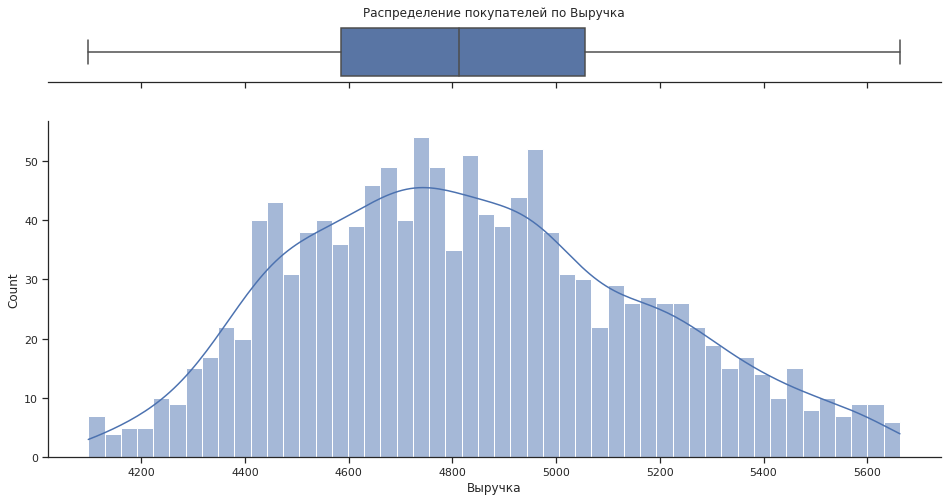

In [38]:
print('Выручка за позапрошлый месяц')
print(market_money.query('Период == "препредыдущий_месяц"')['Выручка'].describe())
num_descr(market_money.query('Период == "препредыдущий_месяц"'), 'Выручка', 50)

In [39]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   Минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Время за текущий месяц


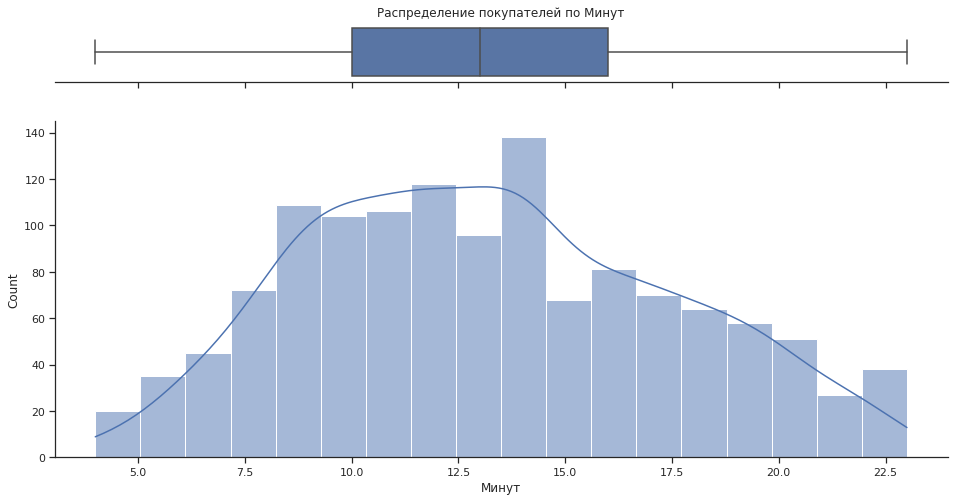

In [40]:
print('Время за текущий месяц')
num_descr(market_time.query('Период == "текущий_месяц"'), 'Минут', 18)

Время за предыдущий месяц


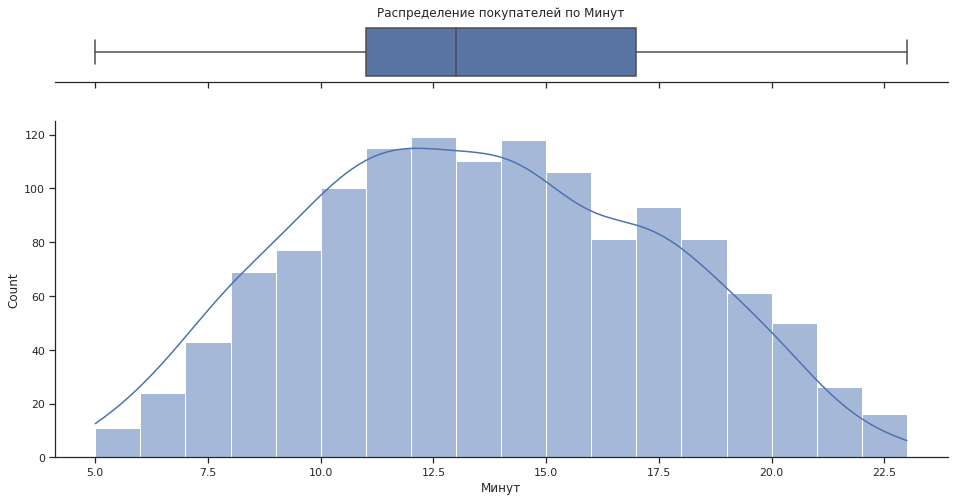

In [41]:
print('Время за предыдущий месяц')
num_descr(market_time.query('Период == "предыдущий_месяц"'), 'Минут', 18)

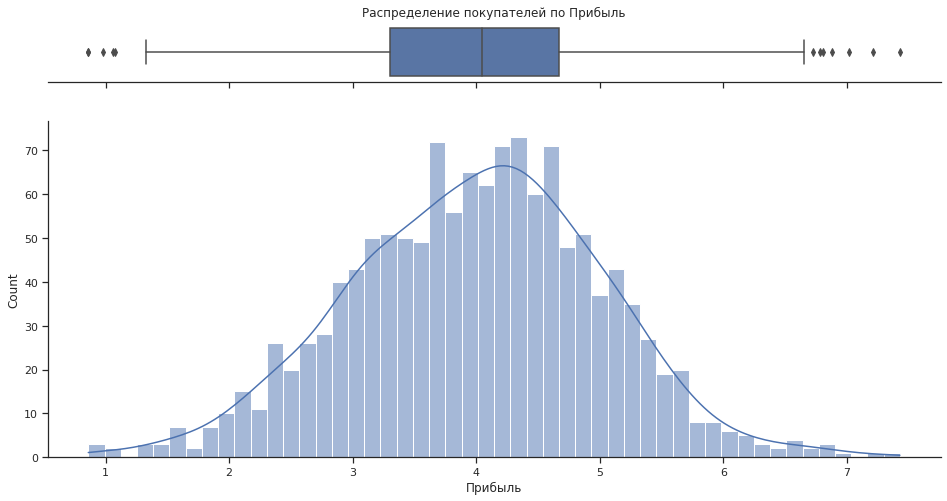

In [42]:
num_descr(money, 'Прибыль', 50)

Заметно лучше. Распределение похоже на нормальное.

In [43]:
#Разобъем таблицу market_file на две новых - с информацией о тех,
#у кого активность осталась на том же уровне и у кого снизилась.

good = market_file.query('Покупательская_активность == "Прежний уровень"')
bad = market_file.query('Покупательская_активность == "Снизилась"')
print(f'Размер выборки с прежней покупательской активностью {good.shape}')
print(f'Размер выборки со сниженной покупательской активностью {bad.shape}')

Размер выборки с прежней покупательской активностью (802, 13)
Размер выборки со сниженной покупательской активностью (498, 13)


In [44]:
#Тут указаны столбцы, с числовыми данными, по которым мы хотим сравнить два набора данных

compare_list = ['Маркет_актив_6_мес',
                'Маркет_актив_тек_мес',
                'Длительность',
                'Акционные_покупки',
                'Средний_просмотр_категорий_за_визит',
                'Неоплаченные_продукты_штук_квартал',
                'Ошибка_сервиса',
                'Страниц_за_визит']

good_columns = [column + '_good' for column in compare_list]
bad_columns = [column + '_bad' for column in compare_list]

# Что будем считать

agg_func = ['min', 'max', 'mean', 'std', 'median']

In [45]:
compare = {'good': good[compare_list].apply(agg_func),
           
           'bad': bad[compare_list].apply(agg_func)
          }

compare = pd.concat(compare, axis = 1)

# Убираем "второй этаж"
compare.columns = [good_columns + bad_columns]

# Тут не придумал как красиво сделать
display(compare[[good_columns[0], bad_columns[0],
                 good_columns[1], bad_columns[1],
                 good_columns[2], bad_columns[2],
                 good_columns[3], bad_columns[3],
                 good_columns[4], bad_columns[4],
                 good_columns[5], bad_columns[5],
                 good_columns[6], bad_columns[6],
                 good_columns[7], bad_columns[7]]])

,Маркет_актив_6_мес_good,Маркет_актив_6_мес_bad,Маркет_актив_тек_мес_good,Маркет_актив_тек_мес_bad,Длительность_good,Длительность_bad,Акционные_покупки_good,Акционные_покупки_bad,Средний_просмотр_категорий_за_визит_good,Средний_просмотр_категорий_за_визит_bad,Неоплаченные_продукты_штук_квартал_good,Неоплаченные_продукты_штук_квартал_bad,Ошибка_сервиса_good,Ошибка_сервиса_bad,Страниц_за_визит_good,Страниц_за_визит_bad
min,0.90,0.90,3.00,3.00,121.00,110.00,0.11,0.00,1.00,1.00,0.00,0.00,0.00,1.00,3.00,1.00
max,6.60,6.60,5.00,5.00,"1,061.00","1,079.00",0.99,0.99,6.00,6.00,8.00,10.00,9.00,9.00,20.00,18.00
mean,4.57,3.74,4.01,4.01,590.73,619.88,0.24,0.45,3.67,2.63,2.29,3.72,4.34,3.94,9.80,5.57
std,0.85,1.05,0.69,0.71,255.33,239.94,0.16,0.31,1.28,1.23,1.51,2.29,1.98,1.89,3.38,3.45
median,4.40,3.90,4.00,4.00,590.00,634.50,0.21,0.31,4.00,2.00,2.00,4.00,4.00,4.00,10.00,5.00


Что можно сказать по цифрам:  
- средняя маркетинговая активность за последние 6 месяцев выше для активных покупателей
- в среднем покупатели со сниженной активностью покупают больше акционных товаров
- активные покупатели просматривают больше категорий за визит и просматривают больше страниц
- размер неоплаченной корзины больше у неактивных покупателей. Учитывая п.2, веротяно, ждут скидок.

Сравним по типу сервиса, разрешению на рекламу и по любимым категориям.

In [46]:
compare_list_cat = ['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']

Распределение активных покупателей по Тип_сервиса


стандарт    596
премиум     206
Name: Тип_сервиса, dtype: int64

Распределение неактивных покупателей по Тип_сервиса


стандарт    328
премиум     170
Name: Тип_сервиса, dtype: int64

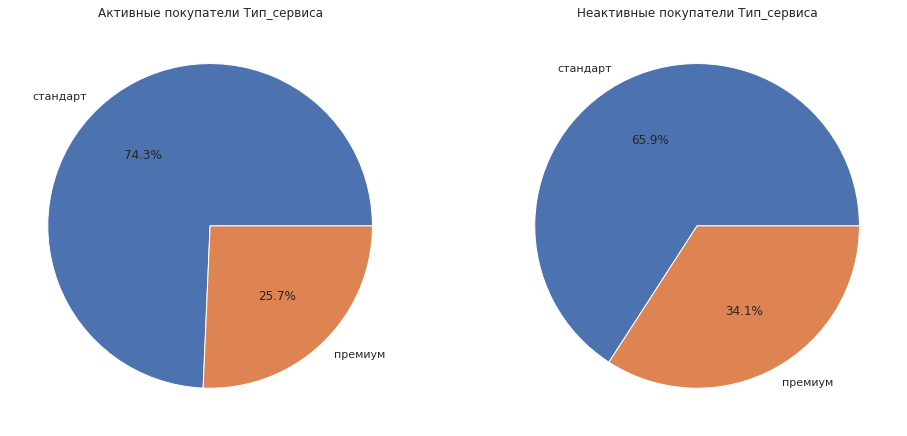

Распределение активных покупателей по Разрешить_сообщать


да     591
нет    211
Name: Разрешить_сообщать, dtype: int64

Распределение неактивных покупателей по Разрешить_сообщать


да     371
нет    127
Name: Разрешить_сообщать, dtype: int64

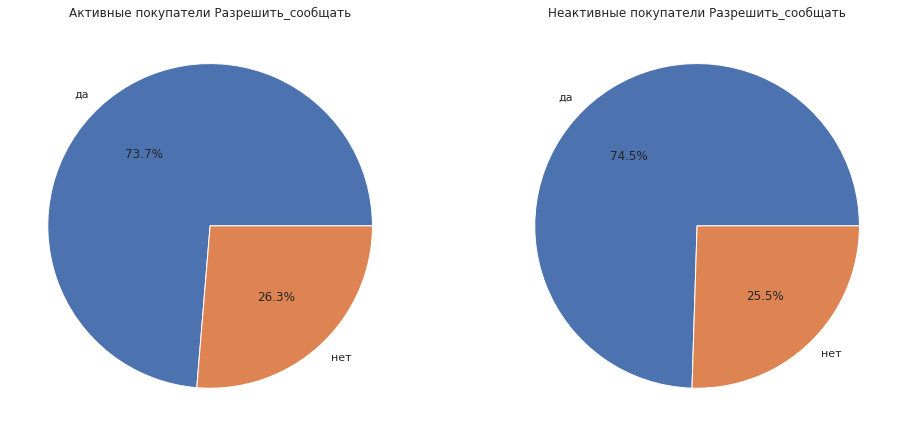

Распределение активных покупателей по Популярная_категория


Товары для детей                        184
Домашний текстиль                       149
Мелкая бытовая техника и электроника    147
Техника для красоты и здоровья          132
Косметика и аксесуары                   118
Кухонная посуда                          72
Name: Популярная_категория, dtype: int64

Распределение неактивных покупателей по Популярная_категория


Товары для детей                        146
Косметика и аксесуары                   105
Домашний текстиль                       102
Кухонная посуда                          66
Техника для красоты и здоровья           52
Мелкая бытовая техника и электроника     27
Name: Популярная_категория, dtype: int64

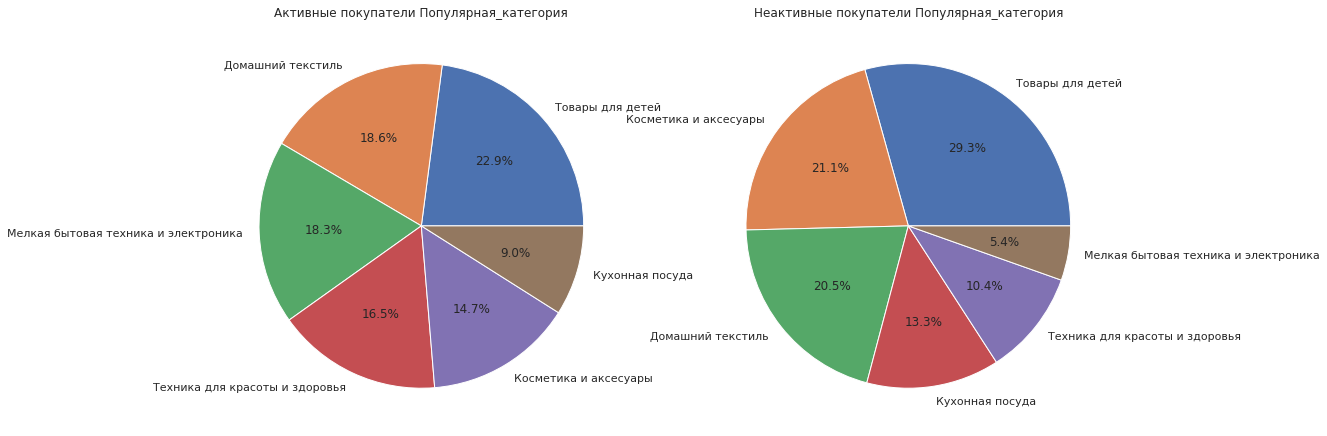

In [47]:
for cat in compare_list_cat:
    print(f'Распределение активных покупателей по {cat}')
    display(good[cat].value_counts())
    
    print(f'Распределение неактивных покупателей по {cat}')
    display(bad[cat].value_counts())
    
    plt.subplot(1, 2, 1)
    good[cat].value_counts().plot(kind='pie', figsize=(16,8), grid=True, autopct="%1.1f%%")
    plt.title(f'Активные покупатели {cat}')
    plt.ylabel('');
    
    plt.subplot(1, 2, 2)
    bad[cat].value_counts().plot(kind='pie', figsize=(16,8), grid=True, autopct="%1.1f%%")
    plt.title(f'Неактивные покупатели {cat}')
    plt.ylabel('');
    plt.show()

- Среди неактивных покупателей доля с подпиской выше (34.1% с подпиской), чем среди активных (25.7% с подпиской).
- Популярные категории отличаются в основном бытовой техникой 18.3% у активных против 5.4% у неактивных.

### Объединение таблиц

In [48]:
# Разобъем датафреймы market_money и market_time по периоду

market_before_last_period = (market_money.query('Период == "препредыдущий_месяц"')
                             .rename(columns={'Выручка':'Выручка_позапрошлый_месяц'})
                             .drop(['Период'], axis=1)
                            )

market_last_period = (market_money.query('Период == "предыдущий_месяц"')
                             .rename(columns={'Выручка':'Выручка_прошлый_месяц'})
                             .drop(['Период'], axis=1)
                      )

market_current_period = (market_money.query('Период == "текущий_месяц"')
                             .rename(columns={'Выручка':'Выручка_текущий_месяц'})
                             .drop(['Период'], axis=1)
                        )

In [49]:
market_time_last_period = (market_time.query('Период == "предыдущий_месяц"')
                             .rename(columns={'Минут':'Минут_прошлый_месяц'})
                             .drop(['Период'], axis=1)
                          )

market_time_current_period = (market_time.query('Период == "текущий_месяц"')
                             .rename(columns={'Минут':'Минут_текущий_месяц'})
                             .drop(['Период'], axis=1)
                             )

In [50]:
# Объединяем все в общий датафрейм

market = (market_file.merge(market_before_last_period, on='id', how='inner')
                     .merge(market_last_period, on='id', how='inner')
                     .merge(market_current_period, on='id', how='inner')
                     .merge(market_time_last_period, on='id', how='inner')
                     .merge(market_time_current_period, on='id', how='inner')
         )

In [51]:
market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская_активность            1296 non-null   object 
 2   Тип_сервиса                          1296 non-null   object 
 3   Разрешить_сообщать                   1296 non-null   object 
 4   Маркет_актив_6_мес                   1296 non-null   float64
 5   Маркет_актив_тек_мес                 1296 non-null   int64  
 6   Длительность                         1296 non-null   int64  
 7   Акционные_покупки                    1296 non-null   float64
 8   Популярная_категория                 1296 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  Ошибка_сервиса                

In [52]:
market.sample(10)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_позапрошлый_месяц,Выручка_прошлый_месяц,Выручка_текущий_месяц,Минут_прошлый_месяц,Минут_текущий_месяц
1183,216535,Прежний уровень,стандарт,нет,4.70,4,1013,0.21,Мелкая бытовая техника и электроника,4,0,5,9,"4,488.00","4,312.50","4,290.40",15,17
206,215558,Снизилась,стандарт,да,4.60,5,867,0.25,Кухонная посуда,2,6,3,5,"4,968.00","6,658.50","7,212.30",12,14
130,215482,Снизилась,премиум,да,2.70,3,602,0.25,Косметика и аксесуары,2,5,5,2,"4,921.00","6,457.00","6,593.50",12,10
193,215545,Снизилась,стандарт,да,4.60,4,755,0.94,Кухонная посуда,3,7,5,5,"4,567.00","4,826.50","5,306.20",9,9
1225,216577,Прежний уровень,стандарт,нет,5.40,5,347,0.26,Мелкая бытовая техника и электроника,4,4,5,9,"4,945.00","4,783.00","5,053.40",16,16
2,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,"4,793.00","6,158.00","6,610.40",11,13
360,215712,Снизилась,премиум,да,3.50,4,794,0.93,Кухонная посуда,3,7,8,6,"4,668.00","5,383.50","5,955.50",12,10
239,215591,Снизилась,стандарт,нет,5.60,4,631,0.40,Товары для детей,3,1,2,2,"4,728.00","5,175.00","5,804.20",7,7
778,216130,Прежний уровень,стандарт,да,3.30,3,322,0.24,Товары для детей,5,0,5,3,"5,139.00","5,256.00","5,284.60",18,20
295,215647,Снизилась,стандарт,да,3.90,5,529,0.22,Товары для детей,2,7,2,2,"4,372.00","3,868.00","4,138.40",10,9


### Корреляционный анализ

In [53]:
columns = market.columns
# список интервальных признаков
interval_cols = ['Маркет_актив_6_мес', 
                 'Маркет_актив_тек_мес', 
                 'Длительность', 
                 'Акционные_покупки', 
                 'Средний_просмотр_категорий_за_визит', 
                 'Неоплаченные_продукты_штук_квартал', 
                 'Ошибка_сервиса', 
                 'Страниц_за_визит', 
                 'Выручка_позапрошлый_месяц', 
                 'Выручка_прошлый_месяц', 
                 'Выручка_текущий_месяц', 
                 'Минут_прошлый_месяц', 
                 'Минут_текущий_месяц']

In [54]:
phik_overview = market[columns[1:]].phik_matrix(interval_cols=interval_cols)

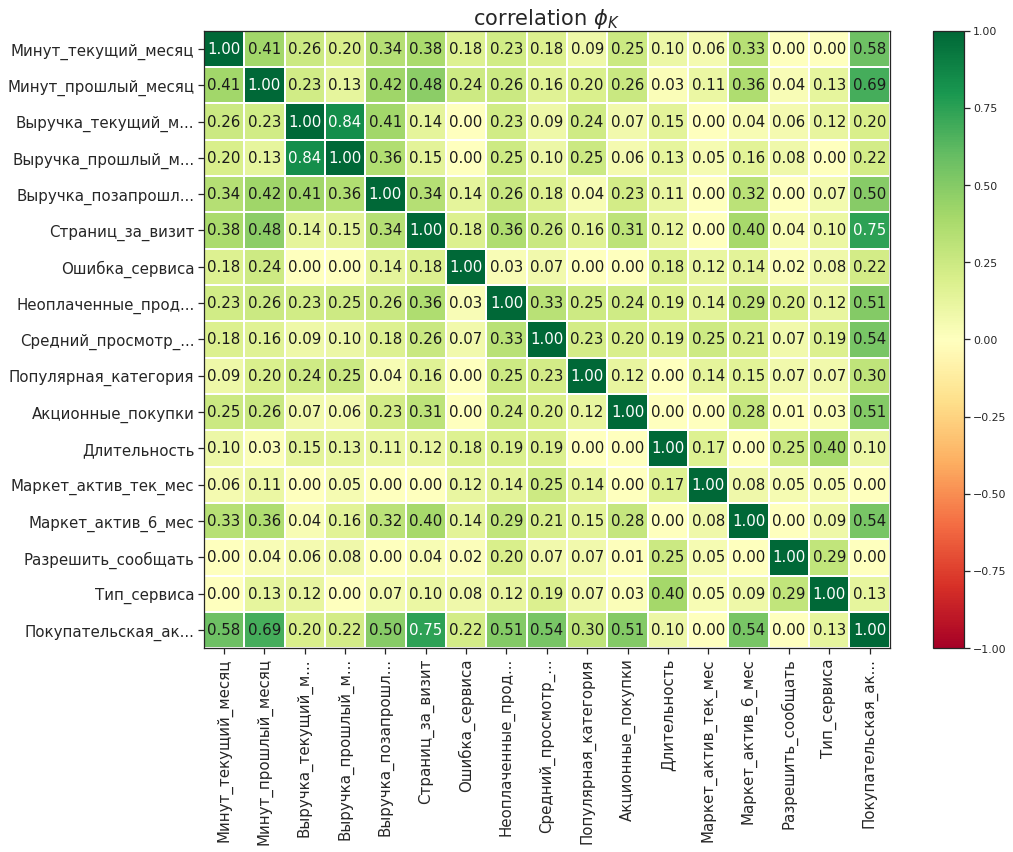

In [55]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

- Целевой признак имеет сильную вазимосвязь с признаками `Страниц_за_визит` и `Минут_прошлый_месяц`.
- С признаками `Минут_текущий_месяц`, `Выручка_позапрошлый_месяц`, `Неоплаченные_продукты_штук_квартал`, `Средний_просмотр_категорий_за_визит`, `Акицонные_покупки` и `Маркет_актив_6_мес` имеется хорошая взаимосвязь.
- С признаками `Маркет_актив_тек_мес` и `Разрешить_сообщать` нет взаимосвязи.

Мультиколлинеарность у признаков не наблюдается.

### Использование пайплайнов

In [56]:
# Зафиксируем константы
RANDOM_STATE = 777
TEST_SIZE = 0.25

In [57]:
# Преобразуем целевую переменную
market['Покупательская_активность'] = market['Покупательская_активность'].apply(
    lambda x: 0 if x == 'Снизилась' else 1)

In [58]:
market['Покупательская_активность'].value_counts()

1    802
0    494
Name: Покупательская_активность, dtype: int64

In [59]:
# Подготовим тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(
    market.drop(['id', 'Покупательская_активность'], axis=1),
    market['Покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market['Покупательская_активность'])

X_train.shape, X_test.shape

((972, 16), (324, 16))

In [60]:
# Создаём списки с названиями признаков

ohe_columns = ['Тип_сервиса', 'Популярная_категория','Разрешить_сообщать']
num_columns = ['Маркет_актив_тек_мес', 'Маркет_актив_6_мес', 'Длительность',
               'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал','Ошибка_сервиса',
               'Страниц_за_визит', 'Выручка_текущий_месяц', 'Выручка_прошлый_месяц', 
               'Выручка_позапрошлый_месяц', 'Минут_прошлый_месяц', 'Минут_текущий_месяц']

In [61]:
# Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

In [62]:
# создаём общий пайплайн для подготовки данных

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [63]:
# создаём итоговый пайплайн: подготовка данных и модель

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [64]:


param_grid = [
     # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели SVC()
    {
        'models': [SVC(kernel='rbf', probability=True)],
        'models__degree': range(2, 5),
        'models__C': range(1, 5),
        'models__gamma': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    n_iter=10, # указанная ниже модель была получена на 100 итерациях
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [65]:
randomized_search.fit(X_train, y_train)

y_test_pred = randomized_search.predict_proba(X_test)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Тип_сервиса',
                                                   'Популярная_категория',
                                                   'Разрешить_сообщать']),
                                                 ('num', StandardScaler(),
                                                  ['Маркет_акт

Лучший результат показала модель лоистической регрессии, с С=1.

### Анализ важности признаков

In [66]:
# Количество сэмплов для эксплорера, чтобы не ждать 3-4 часа.
COUNT = 10
 
# Извлечение лучшей модели из результатов RandomizedSearchCV
best_model = randomized_search.best_estimator_.named_steps['models']

# Предобработка данных через пайплайн без конечной модели
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Получаем имена признаков после OneHotEncoder
ohe_temp = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
ohe_temp.fit(X_train[ohe_columns])
ohe_feature_names = ohe_temp.get_feature_names()

# Для StandardScaler используем имена как есть
num_feature_names = num_columns

# Объединяем все имена признаков в один список
all_feature_names = np.concatenate([ohe_feature_names, num_feature_names])

# Создаем DataFrame с соответствующими именами колонок
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

# Семпл данных для KernelExplainer
X_train_preprocessed_smpl = shap.sample(X_train_preprocessed_df, COUNT, random_state=RANDOM_STATE)
X_test_preprocessed_smpl = shap.sample(X_test_preprocessed_df, COUNT, random_state=RANDOM_STATE)

# Используем KernelExplainer
explainer = shap.KernelExplainer(best_model.predict_proba, X_train_preprocessed_smpl)
shap_values = explainer.shap_values(X_test_preprocessed_smpl)

  0%|          | 0/10 [00:00<?, ?it/s]

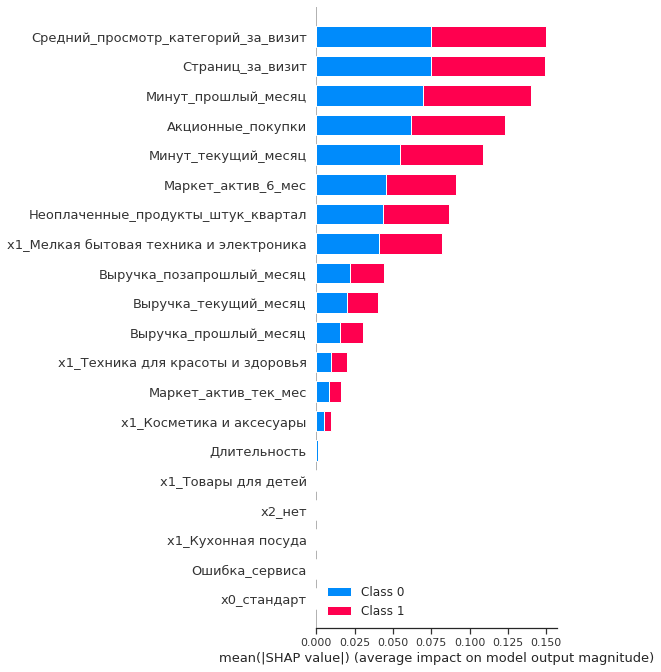

In [67]:
# Построение графика с именами признаков
shap.summary_plot(shap_values, X_test_preprocessed_smpl)

Категории которые сильнее всего влияют на то, к какой категории будет отнесен клиент:  
- `Минут_прошлый_месяц`, `Акционные_покупки`,`Страниц_за_визит`,`Средний_просмотр_категорий_за_визит`,`Минут_текущий_месяц`,  `Неоплаченные_продукты_штук_квартал`,`Маркет_актив_6_мес`  
- При этом `Выручка`, `ошибка_сервиса`, `Длительность` регистрации не влияют на отнесение к той или иной категории.

### Сегментация покупателей

#### Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

In [71]:
# Обучим модель на всех данных и посмотрим для кого модель предсказала снижение активности.
X = market.drop(['id', 'Покупательская_активность'], axis=1)
predictions = randomized_search.predict_proba(X)[:, 1]

#### Выберите группу покупателей и предложите, как увеличить её покупательскую активность

In [72]:
# Отберем пользователей для которых модель с большой долей вероятности прогнозирует снижение активности
threshold = 0.2

mask = np.where(predictions < 0.2, True, False)

X[mask].shape

(322, 16)

In [73]:
# Создадим промежуточный датасет с покупателями, для которых прогнозируется снижение активности
potential_low_activity = X[mask]
potential_low_activity.describe()

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_позапрошлый_месяц,Выручка_прошлый_месяц,Выручка_текущий_месяц,Минут_прошлый_месяц,Минут_текущий_месяц
count,322.00,322.00,322.00,322.00,322.00,322.00,322.00,322.00,322.00,322.00,322.00,322.00,322.00
mean,3.45,4.04,612.04,0.54,2.30,4.33,3.86,4.04,"4,588.81","4,976.13","5,293.07",9.51,9.85
std,1.04,0.71,226.70,0.32,1.03,2.30,1.93,1.85,236.98,809.11,906.22,2.37,2.45
min,0.90,3.00,163.00,0.12,1.00,0.00,1.00,1.00,"4,098.00","2,890.00","2,758.70",5.00,4.00
25%,2.70,4.00,449.00,0.28,2.00,3.00,2.00,3.00,"4,428.25","4,450.25","4,652.18",8.00,8.00
50%,3.50,4.00,622.50,0.36,2.00,4.00,3.00,4.00,"4,597.00","5,103.00","5,314.55",9.00,10.00
75%,4.10,5.00,788.75,0.93,3.00,6.00,5.00,5.00,"4,751.00","5,561.88","5,988.12",11.00,11.00
max,5.70,5.00,"1,072.00",0.99,6.00,10.00,8.00,13.00,"5,532.00","6,716.50","7,799.40",16.00,18.00


In [74]:
# Создадим промежуточный датасет с покупателями, для которых прогнозируется активность на прежнем уровне
potential_same_activity = X[~mask]
potential_same_activity.describe()

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_позапрошлый_месяц,Выручка_прошлый_месяц,Выручка_текущий_месяц,Минут_прошлый_месяц,Минут_текущий_месяц
count,974.00,974.00,974.00,974.00,974.00,974.00,974.00,974.00,974.00,974.00,974.00,974.00,974.00
mean,4.52,4.00,599.97,0.25,3.59,2.35,4.29,9.56,"4,917.99","4,937.99","5,219.92",14.78,14.32
std,0.85,0.69,256.24,0.17,1.30,1.57,1.95,3.52,320.26,661.29,808.82,3.44,4.09
min,1.50,3.00,121.00,0.11,1.00,0.00,0.00,1.00,"4,157.00","2,909.00","2,952.20",7.00,4.00
25%,4.00,4.00,395.00,0.16,3.00,1.00,3.00,7.00,"4,674.00","4,517.00","4,718.12",12.00,11.00
50%,4.40,4.00,602.00,0.22,4.00,2.00,4.00,9.00,"4,904.00","4,985.75","5,147.15",15.00,14.00
75%,5.20,4.00,812.75,0.27,5.00,3.75,6.00,12.00,"5,157.25","5,363.50","5,658.35",17.00,17.00
max,6.60,5.00,"1,079.00",0.99,6.00,8.00,9.00,20.00,"5,663.00","6,869.50","7,605.30",23.00,23.00


In [ ]:
X['Выручка_текущий_месяц'].mean()

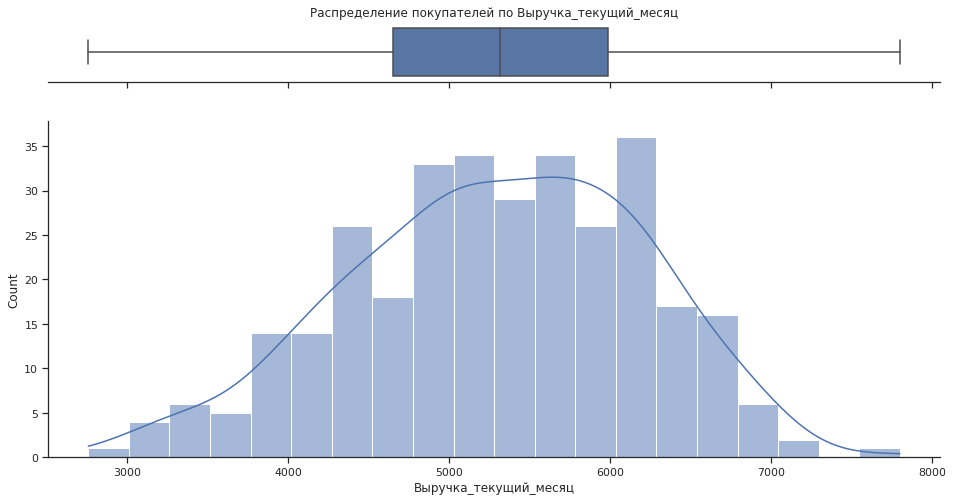

In [75]:
#Среднее значение для всего датасета выручка 5238.1. Для тех у кого прогнозируется сниженеи активности 5,293.96 
num_descr(potential_low_activity, 'Выручка_текущий_месяц', 20)

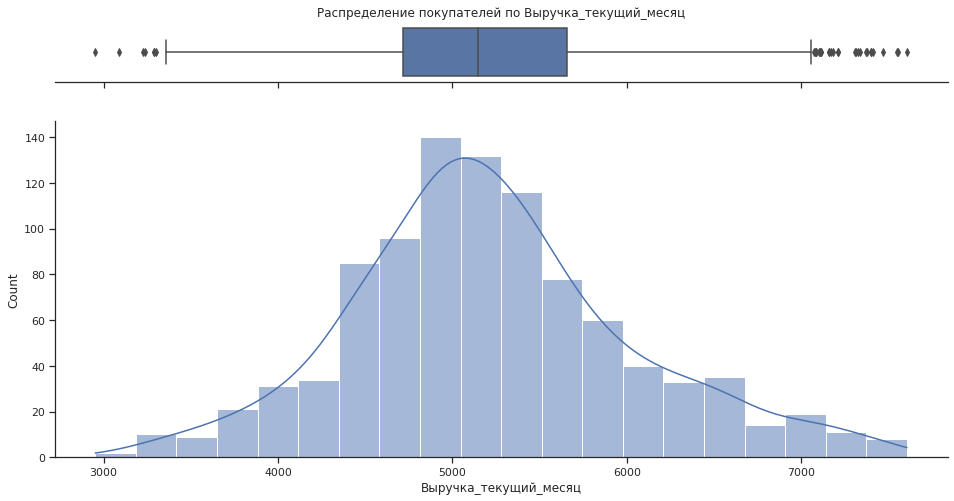

In [76]:
num_descr(potential_same_activity, 'Выручка_текущий_месяц', 20)

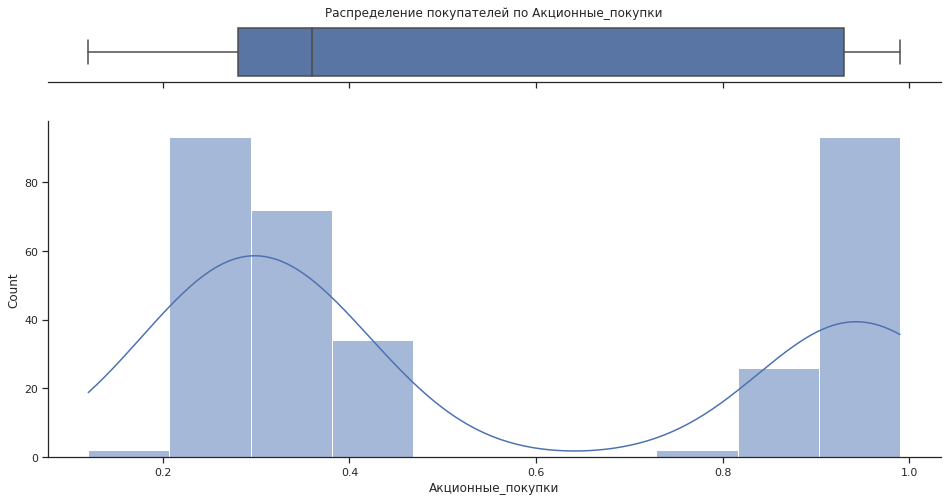

In [77]:
#Среднее значение для всего датасета 0.32. Для тех у кого прогнозируется сниженеи активности 0.55.
num_descr(potential_low_activity, 'Акционные_покупки', 10)

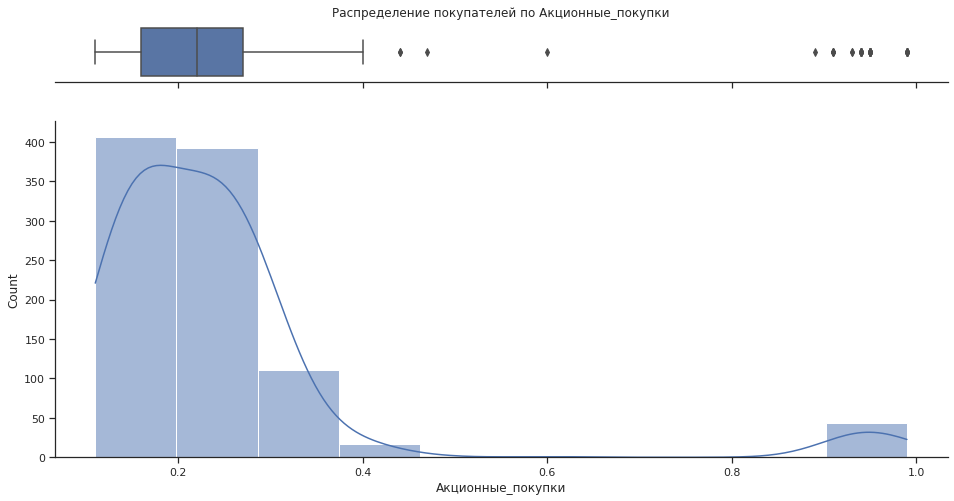

In [78]:
num_descr(potential_same_activity, 'Акционные_покупки', 10)

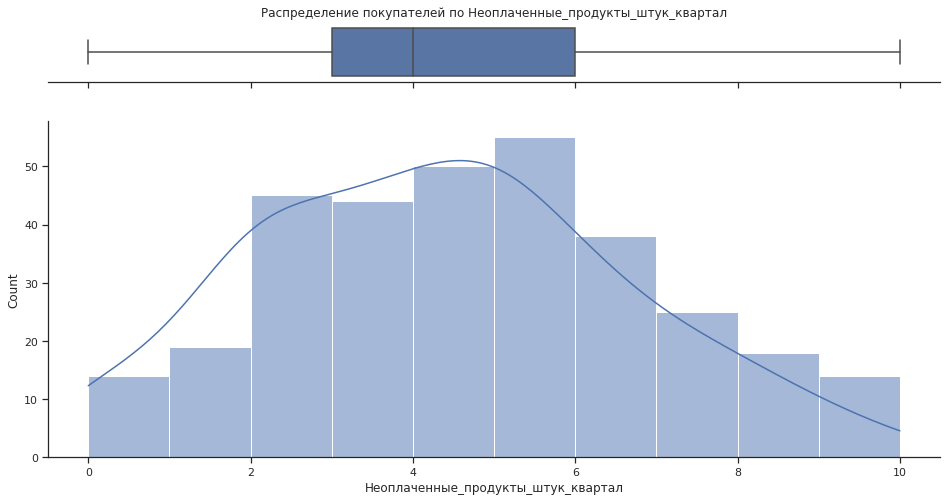

In [79]:
# Среднее значение для всего датасета 2.84. Для тех у кого прогнозируется сниженеи активности 4.37.
num_descr(potential_low_activity, 'Неоплаченные_продукты_штук_квартал', 10)

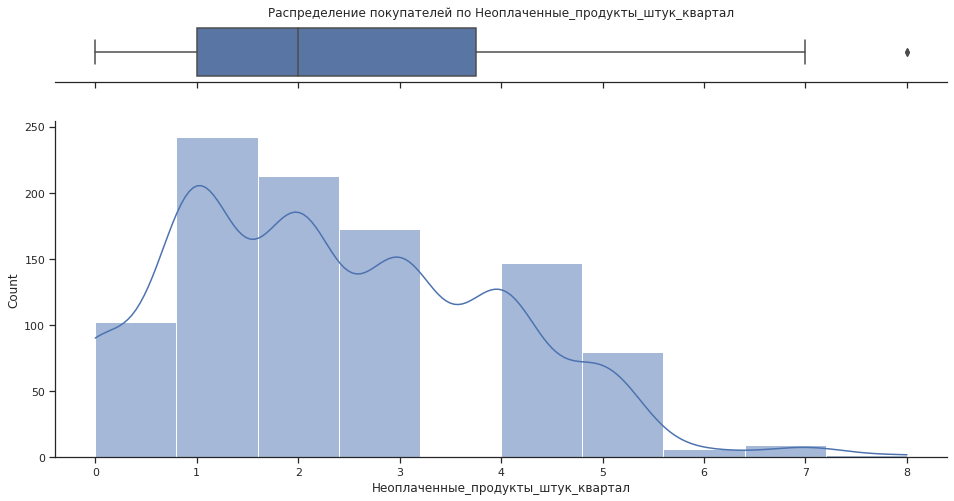

In [80]:
num_descr(potential_same_activity, 'Неоплаченные_продукты_штук_квартал', 10)

#### Сделайте выводы о сегментах

Чтобы понять, какую категорию покупателей нужно стимулировать, необходимо следить за тем, сколько времени пользователи проводят на сайте и сколько товаров в корзину добавляют.  

При снижении времени проведенном на сайте и количестве просмотренных страниц, эти категории пользователей можно стимулировать маркетинговыми акциями.  
Можно заметить, что в корзине у тех, у кого прогнозируется снижение активности находится больше неоплаченых товаров. При этом они активнее покупают по акциям.

### Вывод

Перед началом проекта перед нами стояла задача:
1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

Исходные данные были предоставлены в 4х таблицах (описание в первом пункте).  
- Сами данные были достаточно качественными
- Данные не содержали пропусков, были устранены некоторые опечатки.
- Удалили аномальные значения из таблицы market_money.

1. Для поиска лучше модели, мы провели корреляционный анализ и исключили из модели признаки с нулевым коэффициентом.
2. Создали пайплайн, обучили четыре модели с различными гиперпараметрами.
3. Лучшей моделью оказалась модель лоистической регрессии, с С=1.  
   Метрика лучшей модели на тренировочной выборке: 0.904  
   Метрика ROC-AUC на тестовой выборке: 0.907

Интернет-магазину необходимо обращать внимание на время, которое пользователи проводят на сайте, и на количество посещенных страниц.  
Рекомендуется стимулировать покупателей, для которых прогнозируется снижение активности, акциями. Рекомендуемая категория = мелкая бытовая техника и электроника, так как у нее самое высокое влияние на прогноз.

Так же рекомендуется не снижать маркетинговую активность. На длительном горизонте она влияет на активность покупателей.